# qPCR assay faithfully and reproducibly detects exported RNA

Key technical controls reveal that qPCR assay for exported RNA faithfully and reproducibly detects cDNA (originating from RNA) and not DNA (such as plasmid DNA).

# Introduction

## Imports

In [1]:
import sys
import os
import time

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
import qpcr_tools as qp

In [3]:
# Set pandas display options
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Set plot display options
FONTSIZE = 8  # universal fontsize
params = {
    'font.size': FONTSIZE,
    'axes.titlesize': FONTSIZE,
    'axes.labelsize': FONTSIZE,
    'legend.fontsize': FONTSIZE,
    'xtick.labelsize': FONTSIZE,
    'ytick.labelsize': FONTSIZE,
    'font.family': "Helvetica",
    'mathtext.fontset': 'custom',
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 300
   }
mpl.rcParams.update(params)
sns.set_style("ticks", {'axes.grid' : False})

# Set plot output options
output_dir = "outs/qPCR_NoRT"
output_suffix = ""
output_formats = [".png", ".pdf"]

mpl.rc('savefig', dpi=300)

# Define convenience function for saving figures

savefig = True
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0.1}

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    if savefig:
        for output_format in output_formats:
            fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

In [4]:
# Report plot parameters
sns.plotting_context()

{'font.size': 8.0,
 'axes.labelsize': 8.0,
 'axes.titlesize': 8.0,
 'xtick.labelsize': 8.0,
 'ytick.labelsize': 8.0,
 'legend.fontsize': 8.0,
 'legend.title_fontsize': None,
 'axes.linewidth': 0.8,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.5,
 'lines.markersize': 6.0,
 'patch.linewidth': 1.0,
 'xtick.major.width': 0.8,
 'ytick.major.width': 0.8,
 'xtick.minor.width': 0.6,
 'ytick.minor.width': 0.6,
 'xtick.major.size': 3.5,
 'ytick.major.size': 3.5,
 'xtick.minor.size': 2.0,
 'ytick.minor.size': 2.0}

# Load data

## Load qPCR data

In [5]:
infile = "../preprocessed_data/qPCR_data/qPCR_NoRT_Cq_plate1.csv"

cq_raw_plate1 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate1.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate1.set_index("Well", inplace=True)

print(cq_raw_plate1.shape)
cq_raw_plate1.head()

(43, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A01,SYBR,mCherry,Unkn-01,Well1,RT,21.306337,21.157597,0.132741,43972.903479,4.643185,48156.855879,3748.876637
A02,SYBR,mCherry,Unkn-03,Well2,RT,19.808360,19.760175,0.074307,107565.056327,5.031671,110778.315885,4975.363329
A03,SYBR,mCherry,Unkn-05,Well3,RT,20.146557,19.953760,0.231928,87894.740415,4.943963,99262.334304,14073.446515
A04,SYBR,mCherry,Unkn-07,Well4,RT,31.790145,31.481025,0.267798,84.005898,1.924310,101.872878,15.480181
B01,SYBR,mCherry,Unkn-01,Well1,RT,21.115283,21.157597,0.132741,49287.071834,4.692733,48156.855879,3748.876637


In [6]:
infile = "../preprocessed_data/qPCR_data/qPCR_NoRT_Cq_plate2.csv"

cq_raw_plate2 = pd.read_csv(infile, header=0)

columns_to_drop = ["Unnamed: 0", "Well Note", "Set Point"]
cq_raw_plate2.drop(columns_to_drop, axis=1, inplace=True)
cq_raw_plate2.set_index("Well", inplace=True)

print(cq_raw_plate2.shape)
cq_raw_plate2.head()

(33, 12)


,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev
Well,,,,,,,,,,,,
A05,SYBR,mCherry,Unkn-09,Well13,RT,33.513576,34.037065,0.534529,34.087699,1.532598,25.864388,7.979486
A06,SYBR,mCherry,Unkn-11,Well14,RT,31.550696,31.680099,0.312043,108.474026,2.035326,101.605733,17.724492
B05,SYBR,mCherry,Unkn-09,Well13,RT,34.581989,34.037065,0.534529,18.153418,1.258958,25.864388,7.979486
B06,SYBR,mCherry,Unkn-11,Well14,RT,31.453576,31.680099,0.312043,114.868219,2.060200,101.605733,17.724492
C05,SYBR,mCherry,Unkn-09,Well13,RT,34.015630,34.037065,0.534529,25.352046,1.404013,25.864388,7.979486


In [7]:
# Load metadata (includes sample inputs and volumes for calculating total molecule abundance)
infile = "../preprocessed_data/qPCR_data/qPCR_NoRT_metadata.csv"
metadata = pd.read_csv(infile, index_col=0, header=0)
metadata = metadata.reset_index()
print(metadata.shape)
metadata.head()

(12, 12)


,Sample,Biological Set Name,RNA_input_ng,RNA_yield_ug,volume_supernatant_extracted_mL,description,xticklabel,xticklabel_simple,color,legend_label,well_group,replicate_group
0,Well1,RT,1.3,4.28,0.14,Gag-MCP + mCherry-MS2x12 (RT),Gag-MCP + mCh-MS2x12 (RT),Gag-MCP + mCh-MS2x12,#54278f,Exporter and packaging signal,Gag-MCP + mCherry-MS2x12 (RT),1
1,Well2,RT,1.3,3.40,0.14,Gag-MCP + mCherry-MS2x12 (RT),Gag-MCP + mCh-MS2x12 (RT),Gag-MCP + mCh-MS2x12,#54278f,Exporter and packaging signal,Gag-MCP + mCherry-MS2x12 (RT),2
2,Well3,RT,1.3,3.32,0.14,Gag-MCP + mCherry-MS2x12 (RT),Gag-MCP + mCh-MS2x12 (RT),Gag-MCP + mCh-MS2x12,#54278f,Exporter and packaging signal,Gag-MCP + mCherry-MS2x12 (RT),3
3,Well4,RT,1.3,4.24,0.14,Gag-MCP + mCherry (RT),Gag-MCP + mCh (RT),Gag-MCP + mCh,#006d2c,No packaging signal,Gag-MCP + mCherry (RT),2
4,Well13,RT,1.3,4.56,0.14,mCherry-MS2x12 (RT),mCh-MS2x12 (RT),mCh-MS2x12,#969696,No exporter,mCherry-MS2x12 (RT),2


# Preprocess data

## Merge plates

In [8]:
# Combine

# Add column indicating plate
cq_raw_plate1["Plate"] = "Plate1"
cq_raw_plate2["Plate"] = "Plate2"

# Reset index so that well becomes a column
cq_raw_plate1.reset_index(inplace=True)
cq_raw_plate2.reset_index(inplace=True)

# Concatenate dataframes
cq_raw = pd.concat([cq_raw_plate1, cq_raw_plate2])
print(cq_raw.shape)
cq_raw.head()

(76, 14)


,Well,Fluor,Target,Content,Sample,Biological Set Name,Cq,Cq Mean,Cq Std. Dev,Starting Quantity (SQ),Log Starting Quantity,SQ Mean,SQ Std. Dev,Plate
0,A01,SYBR,mCherry,Unkn-01,Well1,RT,21.306337,21.157597,0.132741,43972.903479,4.643185,48156.855879,3748.876637,Plate1
1,A02,SYBR,mCherry,Unkn-03,Well2,RT,19.808360,19.760175,0.074307,107565.056327,5.031671,110778.315885,4975.363329,Plate1
2,A03,SYBR,mCherry,Unkn-05,Well3,RT,20.146557,19.953760,0.231928,87894.740415,4.943963,99262.334304,14073.446515,Plate1
3,A04,SYBR,mCherry,Unkn-07,Well4,RT,31.790145,31.481025,0.267798,84.005898,1.924310,101.872878,15.480181,Plate1
4,B01,SYBR,mCherry,Unkn-01,Well1,RT,21.115283,21.157597,0.132741,49287.071834,4.692733,48156.855879,3748.876637,Plate1


## Map samples to metadata

In [9]:
# Merge Cq with metadata, using Sample and Biological Set Name as keys
quant = pd.merge(left=cq_raw, right=metadata, on=["Sample", "Biological Set Name"])

## Set index columns as categorical and specify order

In [10]:
# Set desired order
samples_ordered = ["Well1",
                   "Well2",
                   "Well3",
                   "Well4",
                   "Well13",
                   "Well14"]

biological_set_name_ordered = ["No RT", "RT"]

# Convert columns to categorical
quant["Sample"] = pd.Categorical(quant["Sample"], samples_ordered)
quant["Biological Set Name"] = pd.Categorical(quant["Biological Set Name"], biological_set_name_ordered)

# Sort values into desired order
quant["Sample"] = quant["Sample"].sort_values()
quant["Biological Set Name"] = quant["Biological Set Name"].sort_values()

# Generate unique identifier for each Sample and Biological Set Name
quant["Sample and Biological Set Name"] = quant["Sample"].astype(str) + ", " + quant["Biological Set Name"].astype(str)

## Substitute pseudocount for signal below detection limit

In [11]:
# Substitute maximum cycle count for detection limit
# When threshold is not crossed, np.nan is reported in the raw data.
# Substitute np.nan with maximum cycle count plus one, 40 + 1 = 41
# so that we can do a numerical comparison below to plot points at the detection limit.

quant["Cq"] = quant["Cq"].replace(np.nan, 41)
quant["Cq Mean"] = quant["Cq Mean"].replace(0, 41)  # Do same for mean Cq

# Substitute pseudocount for samples below detection limit
PSEUDOCOUNT = 0.5
quant.loc[quant["Cq"] == 41, "Starting Quantity (SQ)"] = PSEUDOCOUNT

## Calculate total starting molecules

In [12]:
PROTOCOL_EFFICIENCY = 0.005957820738  # Efficiency of extraction, DNase, RT

In [13]:
# Normalize by input mass of RNA
quant["SQ_per_ng"] = quant["Starting Quantity (SQ)"] / quant["RNA_input_ng"]  # molecules per ng of RNA input

# Normalize by supernatant volume
quant["SQ_per_mL"] = quant["SQ_per_ng"] * 1000 * quant["RNA_yield_ug"] * (1/quant["volume_supernatant_extracted_mL"])

# Calculate total molecules in supernatant
quant["molecules"] = quant["SQ_per_mL"] * 1  # total volume is 1 mL

# Calculate RNA molecules in supernatant
quant["RNA molecules"] = quant["molecules"] * (1/PROTOCOL_EFFICIENCY)

## Summarize replicates

In [14]:
# Calculate mean across replicates
quant_summary_temp = quant.groupby(["Biological Set Name", "Sample"]).mean()

# Merge metadata with summary
cols_without_duplicates = list(metadata.columns.difference(quant_summary_temp.columns))
quant_summary = pd.merge(left=quant_summary_temp,
                         right=metadata[cols_without_duplicates],
                         on=["Biological Set Name", "Sample"])
quant_summary = quant_summary.set_index(["Biological Set Name", "Sample"])

# Sort into desired order
quant_summary = quant_summary.sort_index(ascending=[False, True])

print(quant_summary.shape)
quant_summary.head()

(12, 21)


Cq    Cq Mean  Cq Std. Dev  Starting Quantity (SQ)  Log Starting Quantity        SQ Mean   SQ Std. Dev  RNA_input_ng  RNA_yield_ug  volume_supernatant_extracted_mL  replicate_group     SQ_per_ng     SQ_per_mL     molecules  RNA molecules    color                    description                   legend_label                     well_group                 xticklabel     xticklabel_simple
Biological Set Name Sample                                                                                                                                                                                                                                                                                                                                                                                                             
RT                  Well1   21.157597  21.157597     0.132741            48156.855879               4.681759   48156.855879   3748.876637           1.3          4.28                             0.14              1.0  37043.735292  1.132480e+09  1.132480e+09   1.900829e+11  #54278f  Gag-MCP + mCherry-MS2x12 (RT)  Exporter and packaging signal  Gag-MCP + mCherry-MS2x12 (RT)  Gag-MCP + mCh-MS2x12 (RT)  Gag-MCP + mCh-MS2x12
                    Well2   19.760175  19.760175     0.074307           110778.315885               5.044167  110778.315885   4975.363329           1.3          3.40                             0.14              2.0  85214.089142  2.069485e+09  2.069485e+09   3.473560e+11  #54278f  Gag-MCP + mCherry-MS2x12 (RT)  Exporter and packaging signal  Gag-MCP + mCherry-MS2x12 (RT)  Gag-MCP + mCh-MS2x12 (RT)  Gag-MCP + mCh-MS2x12
                    Well3   19.953760  19.953760     0.231928            99262.334304               4.993963   99262.334304  14073.446515           1.3          3.32                             0.14              3.0  76355.641772  1.810720e+09  1.810720e+09   3.039231e+11  #54278f  Gag-MCP + mCherry-MS2x12 (RT)  Exporter and packaging signal  Gag-MCP + mCherry-MS2x12 (RT)  Gag-MCP + mCh-MS2x12 (RT)  Gag-MCP + mCh-MS2x12
                    Well4   31.481025  31.481025     0.267798              101.872878               2.004477     101.872878     15.480181           1.3          4.24                             0.14              2.0     78.363752  2.373302e+06  2.373302e+06   3.983507e+08  #006d2c         Gag-MCP + mCherry (RT)            No packaging signal         Gag-MCP + mCherry (RT)         Gag-MCP + mCh (RT)         Gag-MCP + mCh
                    Well13  34.037065  34.037065     0.534529               25.864388               1.398523      25.864388      7.979486           1.3          4.56                             0.14              2.0     19.895683  6.480308e+05  6.480308e+05   1.087698e+08  #969696            mCherry-MS2x12 (RT)                    No exporter            mCherry-MS2x12 (RT)            mCh-MS2x12 (RT)            mCh-MS2x12

## Summarize biological replicates

In [15]:
# Calculate mean across replicates (summarizing technical and biological replicates, which share the same description)
quant_summary_biorep_temp = quant.groupby(["well_group"]).mean()

# Merge metadata with summary
cols_without_duplicates = list(metadata.columns.difference(quant_summary_biorep_temp.columns))
quant_summary_biorep = pd.merge(left=quant_summary_biorep_temp,
                         right=metadata[cols_without_duplicates],
                         on=["well_group"])

# Drop duplicate rows (corresponding to different Samples, e.g. Well 1, Well 2, and Well 3)
quant_summary_biorep = quant_summary_biorep.sort_values(by="Sample").drop_duplicates(subset=["well_group"])

# Set desired order
samples_ordered = ["Well1",
                   "Well2",
                   "Well3",
                   "Well4",
                   "Well13",
                   "Well14"]

biological_set_name_ordered = ["No RT", "RT"]

# Convert columns to categorical for sorting
quant_summary_biorep["Sample"] = pd.Categorical(quant_summary_biorep["Sample"], samples_ordered)
quant_summary_biorep["Biological Set Name"] = pd.Categorical(quant_summary_biorep["Biological Set Name"], biological_set_name_ordered)

# Sort into desired order
quant_summary_biorep = quant_summary_biorep.sort_values(["Biological Set Name", "Sample"], ascending=[False, True])

# Set index
quant_summary_biorep = quant_summary_biorep.set_index(["Biological Set Name", "Sample"])

print(quant_summary_biorep.shape)
quant_summary_biorep

(8, 21)


well_group         Cq    Cq Mean  Cq Std. Dev  Starting Quantity (SQ)  Log Starting Quantity       SQ Mean  SQ Std. Dev  RNA_input_ng  RNA_yield_ug  volume_supernatant_extracted_mL  replicate_group     SQ_per_ng     SQ_per_mL     molecules  RNA molecules    color                       description                   legend_label                    xticklabel     xticklabel_simple
Biological Set Name Sample                                                                                                                                                                                                                                                                                                                                                                                                                    
RT                  Well1      Gag-MCP + mCherry-MS2x12 (RT)  20.290511  20.290511     0.146325            86065.835356               4.906630  86065.835356  7599.228827           1.3      3.666667                             0.14              2.0  66204.488735  1.670895e+09  1.670895e+09   2.804540e+11  #54278f     Gag-MCP + mCherry-MS2x12 (RT)  Exporter and packaging signal     Gag-MCP + mCh-MS2x12 (RT)  Gag-MCP + mCh-MS2x12
                    Well4             Gag-MCP + mCherry (RT)  31.481025  31.481025     0.267798              101.872878               2.004477    101.872878    15.480181           1.3      4.240000                             0.14              2.0     78.363752  2.373302e+06  2.373302e+06   3.983507e+08  #006d2c            Gag-MCP + mCherry (RT)            No packaging signal            Gag-MCP + mCh (RT)         Gag-MCP + mCh
                    Well13               mCherry-MS2x12 (RT)  34.037065  34.037065     0.534529               25.864388               1.398523     25.864388     7.979486           1.3      4.560000                             0.14              2.0     19.895683  6.480308e+05  6.480308e+05   1.087698e+08  #969696               mCherry-MS2x12 (RT)                    No exporter               mCh-MS2x12 (RT)            mCh-MS2x12
                    Well14                      mCherry (RT)  31.680099  31.680099     0.312043              101.605733               2.002183    101.605733    17.724492           1.3      4.320000                             0.14              2.0     78.158256  2.411740e+06  2.411740e+06   4.048025e+08  #969696                      mCherry (RT)                    No exporter                      mCh (RT)                   mCh
No RT               Well1   Gag-MCP + mCherry-MS2x12 (No RT)  37.681209  37.681209     0.619915                9.561572               1.085076      9.339350     7.215323           1.3      3.666667                             0.14              2.0      7.355055  1.787493e+05  1.787493e+05   3.000246e+07  #807dba  Gag-MCP + mCherry-MS2x12 (No RT)  Exporter and packaging signal  Gag-MCP + mCh-MS2x12 (No RT)  Gag-MCP + mCh-MS2x12
                    Well4          Gag-MCP + mCherry (No RT)  41.000000  41.000000     0.000000                0.500000                    NaN      0.000000     0.000000           1.3      4.240000                             0.14              2.0      0.384615  1.164835e+04  1.164835e+04   1.955136e+06  #238b45         Gag-MCP + mCherry (No RT)            No packaging signal         Gag-MCP + mCh (No RT)         Gag-MCP + mCh
                    Well13            mCherry-MS2x12 (No RT)  38.565258  38.565258     1.586161                3.799714               0.550564      3.633047     3.895964           1.3      4.560000                             0.14              2.0      2.922857  9.520162e+04  9.520162e+04   1.597927e+07  #bdbdbd            mCherry-MS2x12 (No RT)                    No exporter            mCh-MS2x12 (No RT)            mCh-MS2x12
                    Well14                   mCherry (No RT)  32.931879  32.931879     2.719047              102.700651               1.681581    102.700651   134.000085  

## Calculate detection limit

In [16]:
DETECTION_LIMIT_SQ = 13.711332098123853  # detection limit (starting molecules) (estimated by Biorad software based on standard curve)

In [17]:
# Convert detection limit to total starting RNA molecules

FRACTION_OF_SUPERNATANT_SAMPLED = (140/1000) * (20/42) * (10/41) * (1/20)  # Fraction of total supernatant volume that was input to qPCR

DETECTION_LIMIT_RNA_MOLECULES = DETECTION_LIMIT_SQ * (1/PROTOCOL_EFFICIENCY) * (1/FRACTION_OF_SUPERNATANT_SAMPLED)

print("Detection limit (molecules):", DETECTION_LIMIT_RNA_MOLECULES)

Detection limit (molecules): 2830722.712606117


# Visualize RT-qPCR assay results with and without reverse transcription (RT) as barplot

In [18]:
# Set colors

color_exporter_Gag = "#31a354"
color_exporter_engineered = "#756bb1"
color_no_packaging_signal = "#737373"
color_no_exporter = "#bdbdbd"

sample_to_color = {"Well1": color_exporter_engineered,
                   "Well4": color_no_packaging_signal,
                   "Well13": color_no_exporter,
                   "Well14": color_no_exporter}

In [19]:
# Select subset among summary

# Set desired order
samples_ordered = ["Well1",
                   "Well4",
                   "Well13",
                   "Well14"]

biological_set_name_ordered = ["RT"]*len(samples_ordered) + ["No RT"]*len(samples_ordered)

index_ordered = list(zip(biological_set_name_ordered, samples_ordered*3))

# Select subset of wells in desired order
quant_summary_subset, _ = qp.select_quant_summary_samples_ordered(quant_summary_biorep, quant, index_ordered)  # select subset of wells in desired order

In [20]:
# Select subset among quant (note that function above does not work properly with a multi-index; this is hacky way to accomplish this; should be fixed in future if we are using multi-indexes)

# Set desired order
samples_ordered = ["Well1",
                   "Well2",
                   "Well3",
                   "Well4",
                   "Well13",
                   "Well14"]

biological_set_name_ordered = ["RT"]*len(samples_ordered) + ["No RT"]*len(samples_ordered)

index_ordered = list(zip(biological_set_name_ordered, samples_ordered*3))

quant_temp = quant.set_index(["Biological Set Name", "Sample"])
quant_subset = quant_temp.loc[index_ordered]
quant_subset = quant_subset.reset_index()

# Take a peek
print(quant_summary_subset.shape)
quant_summary_subset.head()

(8, 21)


well_group         Cq    Cq Mean  Cq Std. Dev  Starting Quantity (SQ)  Log Starting Quantity       SQ Mean  SQ Std. Dev  RNA_input_ng  RNA_yield_ug  volume_supernatant_extracted_mL  replicate_group     SQ_per_ng     SQ_per_mL     molecules  RNA molecules    color                       description                   legend_label                    xticklabel     xticklabel_simple
Biological Set Name Sample                                                                                                                                                                                                                                                                                                                                                                                                                    
RT                  Well1      Gag-MCP + mCherry-MS2x12 (RT)  20.290511  20.290511     0.146325            86065.835356               4.906630  86065.835356  7599.228827           1.3      3.666667                             0.14              2.0  66204.488735  1.670895e+09  1.670895e+09   2.804540e+11  #54278f     Gag-MCP + mCherry-MS2x12 (RT)  Exporter and packaging signal     Gag-MCP + mCh-MS2x12 (RT)  Gag-MCP + mCh-MS2x12
                    Well4             Gag-MCP + mCherry (RT)  31.481025  31.481025     0.267798              101.872878               2.004477    101.872878    15.480181           1.3      4.240000                             0.14              2.0     78.363752  2.373302e+06  2.373302e+06   3.983507e+08  #006d2c            Gag-MCP + mCherry (RT)            No packaging signal            Gag-MCP + mCh (RT)         Gag-MCP + mCh
                    Well13               mCherry-MS2x12 (RT)  34.037065  34.037065     0.534529               25.864388               1.398523     25.864388     7.979486           1.3      4.560000                             0.14              2.0     19.895683  6.480308e+05  6.480308e+05   1.087698e+08  #969696               mCherry-MS2x12 (RT)                    No exporter               mCh-MS2x12 (RT)            mCh-MS2x12
                    Well14                      mCherry (RT)  31.680099  31.680099     0.312043              101.605733               2.002183    101.605733    17.724492           1.3      4.320000                             0.14              2.0     78.158256  2.411740e+06  2.411740e+06   4.048025e+08  #969696                      mCherry (RT)                    No exporter                      mCh (RT)                   mCh
No RT               Well1   Gag-MCP + mCherry-MS2x12 (No RT)  37.681209  37.681209     0.619915                9.561572               1.085076      9.339350     7.215323           1.3      3.666667                             0.14              2.0      7.355055  1.787493e+05  1.787493e+05   3.000246e+07  #807dba  Gag-MCP + mCherry-MS2x12 (No RT)  Exporter and packaging signal  Gag-MCP + mCh-MS2x12 (No RT)  Gag-MCP + mCh-MS2x12

In [21]:
# Substitute detection limit for values under detection limit

# Copy data
quant_summary_subset_clean = quant_summary_subset.copy()
quant_subset_clean = quant_subset.copy()

# Set a constant level for ND
quant_summary_subset_clean.loc[quant_summary_subset_clean["RNA molecules"] < DETECTION_LIMIT_RNA_MOLECULES, "RNA molecules"] = DETECTION_LIMIT_RNA_MOLECULES
quant_subset_clean.loc[quant_subset_clean["RNA molecules"] < DETECTION_LIMIT_RNA_MOLECULES, "RNA molecules"] = DETECTION_LIMIT_RNA_MOLECULES

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


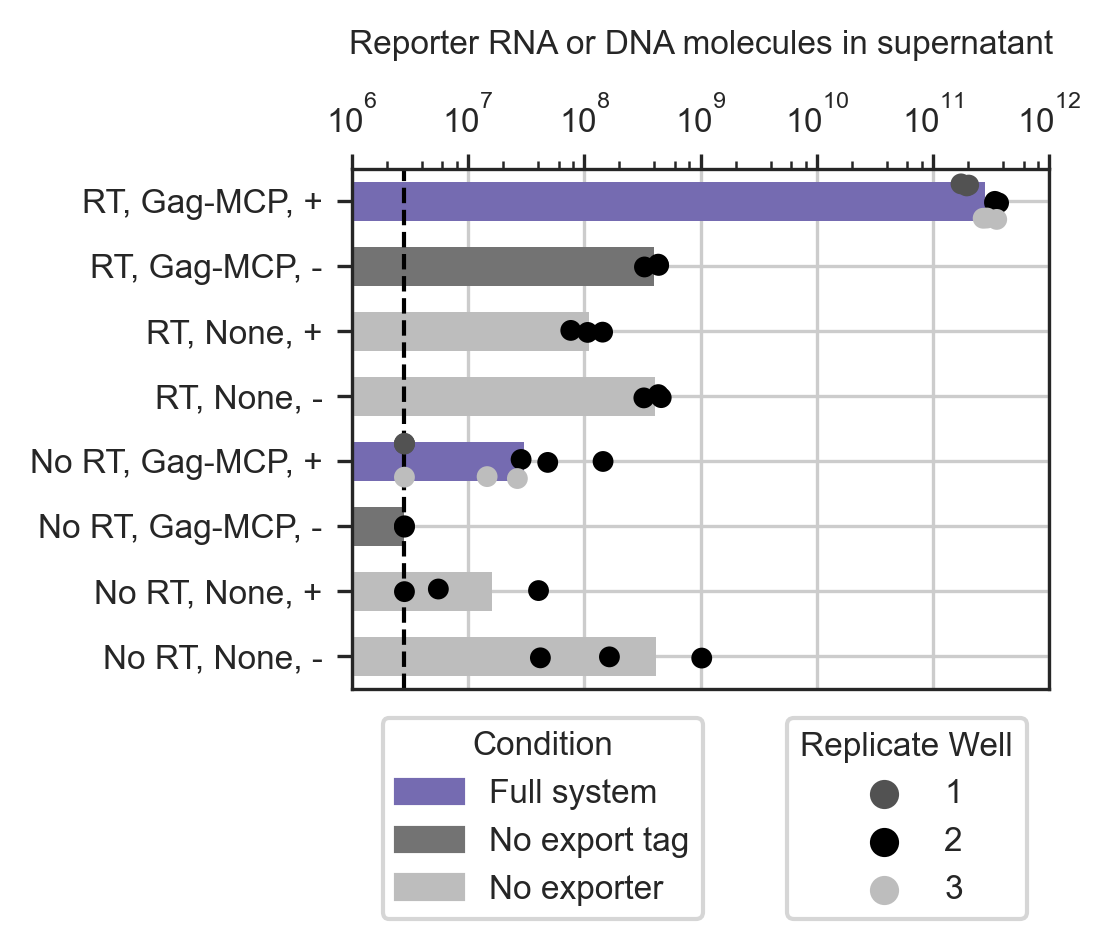

In [22]:
field = "RNA molecules"

sns.set_style("ticks")

fig, ax = plt.subplots(1, 1, figsize=(3,2.25))

# Set axis scaling - must be done first so swarm plot dots do not overlap
ax.set_xscale("log")
ax.set_xlim(1e6, 1e12)


# Get x positions of bars (numerical data)
x = quant_summary_subset_clean[field]

# Set colors
color = [sample_to_color[sample] for sample in quant_summary_subset_clean.reset_index().Sample]

# Specify custom y positions to group bars
y_origin = 0
y_offset = 0.3
y_space = 0.75

y = [y_origin+1*y_offset, y_origin+3*y_offset,
     y_origin+5*y_offset, y_origin+7*y_offset,
     y_origin+7*y_offset+y_space, y_origin+9*y_offset+y_space,
     y_origin+11*y_offset+y_space, y_origin+13*y_offset+y_space,
     y_origin+13*y_offset+2*y_space, y_origin+15*y_offset+2*y_space,
     y_origin+17*y_offset+2*y_space, y_origin+19*y_offset+2*y_space]

# Set y axis limit based on custom y positions
ax.set_ylim(0, max(y) + 0.25 + 0.05)

# Plot bars showing summary of replicates (mean)
ax.barh(y=range(len(x)), width=x, color=color, height=0.6, linewidth=0)

p = sns.stripplot(data=quant_subset_clean,
              y="well_group",
              x=field,
              hue="replicate_group", dodge=True,
              color="#666666", size=5,
              palette=["#525252", "#000000", "#bdbdbd"],
              ax=ax)  # plot swarm of individual replicates

# Set axis aesthetics
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.set_xlabel("Reporter RNA or DNA molecules in supernatant", labelpad=10)
ax.set_ylabel("")
ax.grid(True)

locmaj = mpl.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = mpl.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

yticklabels = ["RT, Gag-MCP, +",
               "RT, Gag-MCP, -",
               "RT, None, +",
               "RT, None, -",
               "No RT, Gag-MCP, +",
               "No RT, Gag-MCP, -",
               "No RT, None, +",
               "No RT, None, -"]
ax.set_yticklabels(yticklabels)


# Add legend
color_legend = [color[0], color[1], color[2]]
label_legend = ["Full system", "No export tag", "No exporter"]
patches = [mpl.patches.Patch(color=c) for c in color_legend]
bbox_to_anchor = (0.02, -0.25)
leg = plt.legend([patches[0], patches[1], patches[2]], label_legend,
                  handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)},
                  loc="center left", bbox_to_anchor=bbox_to_anchor,
                  title="Condition", title_fontsize=FONTSIZE)
ax.add_artist(leg)  # add legend to axis

# Add second legend
handles, labels = p.get_legend_handles_labels()
bbox_to_anchor = (0.6, -0.25)
leg2 = plt.legend(handles=handles, labels=[1, 2, 3],
                  loc="center left", bbox_to_anchor=bbox_to_anchor,
                  title="Replicate Well", title_fontsize=FONTSIZE)

ax.axvline(x=DETECTION_LIMIT_RNA_MOLECULES, ls="--", color="k", lw=1)

save_figure(fig, "barplot_NoRT")